In [1]:
import numpy as np

In [2]:
import numpy.linalg as linalg

In [27]:
class Riemann:
    def __init__(self, L=10, gamma = 5/3, v_l = 0, v_r = 0, ro_l = 1.3, ro_r = 13, p_l = 10, p_r = 1, T = 0.2):
        self.L = L
        self.gamma = gamma
        self.v_l = v_l
        self.v_r = v_r
        self.ro_l = ro_l
        self.ro_r = ro_r
        self.p_l = p_l*1e5
        self.p_r = p_r*1e5
        self.T = T
        self.w0_l = [self.ro_l, self.ro_l*self.v_l, self.p_l/(self.gamma - 1)]
        self.w0_r = [self.ro_r, self.ro_r*self.v_r, self.p_r/(self.gamma - 1)]
        self.cfl_max = 0.01 
        self.tau = 1e-7
        self.h = 0.1
    def generate_grid(self):
        self.matrix = np.zeros([int(self.T/self.tau), int(self.L/self.h), 3])
        self.omegas_T = np.zeros([int(self.T/self.tau), int(self.L/self.h), 3, 3])
        self.omegas_T_inv = np.zeros([int(self.T/self.tau), int(self.L/self.h), 3, 3])
        self.As = np.zeros([int(self.T/self.tau), int(self.L/self.h), 3, 3])
        self.Ls  = np.zeros([int(self.T/self.tau), int(self.L/self.h), 3, 3])
        self.L_mods  = np.zeros([int(self.T/self.tau), int(self.L/self.h), 3, 3])
    def calculate(self):
        for i in range(int(self.T/self.tau)):
            self.count_layer(i)
    def initials(self):
        for i in range(int(self.L/self.h)):
            if (i < int(self.L/self.h) / 2):
                self.matrix[0, i] = self.w0_l
            else:
                self.matrix[0, i] = self.w0_r
    def count_layer(self, n):
        print(f'layer {n} out of {int(self.T/self.tau)}')
        for i in range(int(self.L/self.h)):
            if (n == 0):
                pass
#                 if (i < int(self.L/self.h)):
#                     self.matrix[n, i] = self.w0_l
#                 else:
#                     self.matrix[n, i] = self.w0_r
            else:
                #print('not 0')
                if (i == 0 or i == int(self.L/self.h) - 1) or (n == 0 or n == int(self.T/self.tau) - 1):
                    self.matrix[n, i] = self.matrix[0][i]
                else:
                    a = self.matrix[n-1, i]
                    b_0 = (self.matrix[n-1, i + 1] - self.matrix[n-1, i - 1])/(2*self.h)
                    #print('1', self.matrix[n-1, i + 1])
                    #print('2', self.matrix[n-1, i - 1])
                    #print(b_0)
                    b = self.tau * np.matmul(self.As[n - 1, i], b_0)
                    c_0 = (self.matrix[n-1, i + 1] - self.matrix[n-1, i - 1] + 2*self.matrix[n - 1, i])/(2*self.h)
                    c1 = np.matmul(self.omegas_T_inv[n -1, i], self.L_mods[n -1, i])
                    c2 = np.matmul(c1,self.omegas_T[n -1, i])
                    cf = self.tau*np.matmul(c2, c_0)
                    self.matrix[n, i] = a - b + cf
            #print(self.matrix[n, i])
            cur_w = self.matrix[n , i]
            cur_u = cur_w[1]/cur_w[0]
            cur_e = cur_w[2]/cur_w[0]
            #print(cur_e)
            c = (cur_e*self.gamma*(self.gamma - 1))**(0.5)

            self.omegas_T[n, i] = [[cur_u , c, self.gamma - 1], [-c**2 , 0, self.gamma - 1], [cur_u*c , -c, self.gamma - 1]]
            self.omegas_T_inv[n, i] = linalg.inv(self.omegas_T[n, i])
            self.As[n, i] = [[0, 1, 0], [-cur_u**2, 2*cur_u, self.gamma - 1], [-cur_u*cur_e*self.gamma, cur_e*self.gamma, cur_u]]
            lambdas = linalg.eigvals(self.As[n, i])
            self.Ls[n, i] = [[lambdas[0], 0, 0],[0, lambdas[1], 0],[0, 0, lambdas[2]]]
            self.L_mods[n, i] = [[np.abs(lambdas[0]), 0, 0],[0, np.abs(lambdas[1]), 0],[0, 0, np.abs(lambdas[2])]]
            CFL = self.tau/self.h*max([np.abs(l) for l in lambdas])
            if (CFL > 1):
                print('cfl', CFL)
                print('CFL should be corrected')
                
   

In [31]:
layer = [np.zeros(int(10/0.1)), 3]

In [32]:
layer

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 3]

In [27]:
for i in range(int(10/0.1)):
            
            if (i < int(10/0.1) / 2):
                layer[i] = [0, 0, 1]
            else:
                layer[i] = [2, 4, 5]

IndexError: list assignment index out of range

In [30]:
class Riemann2:
    def __init__(self, L=10, gamma = 5/3, v_l = 0, v_r = 0, ro_l = 13, ro_r = 1.3, p_l = 10, p_r = 1, T = 0.015):
        self.L = L
        self.gamma = gamma
        self.v_l = v_l
        self.v_r = v_r
        self.ro_l = ro_l
        self.ro_r = ro_r
        self.p_l = p_l*1e5
        self.p_r = p_r*1e5
        self.T = T
        self.w0_l = [self.ro_l, self.ro_l*self.v_l, self.p_l/(self.gamma - 1)]
        self.w0_r = [self.ro_r, self.ro_r*self.v_r, self.p_r/(self.gamma - 1)]
        self.cfl_max = 0.01 
        self.tau = 1e-7
        self.h = 0.1
    def calculate(self):
        self.initials()
        time = 0
        layer_number = 0
        while (time < self.T):
            time += self.tau
            layer_number += 1
            self.count_layer(layer_number)
    def initials(self):
        self.matrix = []
        layer = np.zeros([int(self.L/self.h), 3])
        omegas_T = np.zeros([int(self.L/self.h), 3, 3])
        omegas_T_inv = np.zeros([int(self.L/self.h), 3, 3])
        As = np.zeros([int(self.L/self.h), 3, 3])
        Ls = np.zeros([int(self.L/self.h), 3, 3])
        L_mods = np.zeros([int(self.L/self.h), 3, 3])
        
        for i in range(int(self.L/self.h)):
            
            if (i < int(self.L/self.h) / 2):
                layer[i] = self.w0_l
            else:
                layer[i] = self.w0_r
                
            cur_w = layer[i]
            cur_u = cur_w[1]/cur_w[0]
            cur_e = cur_w[2]/cur_w[0]
            #print(cur_e)
            c = (cur_e*self.gamma*(self.gamma - 1))**(0.5)


            omegas_T[i] = [[cur_u , c, self.gamma - 1], [-c**2 , 0, self.gamma - 1], [cur_u*c , -c, self.gamma - 1]]
            omegas_T_inv[i] = linalg.inv(omegas_T[i])
            As[i] = [[0, 1, 0], [-cur_u**2, 2*cur_u, self.gamma - 1], [-cur_u*cur_e*self.gamma, cur_e*self.gamma, cur_u]]
            lambdas = linalg.eigvals(As[i])
            Ls[i] = [[lambdas[0], 0, 0],[0, lambdas[1], 0],[0, 0, lambdas[2]]]
            L_mods[i] = [[np.abs(lambdas[0]), 0, 0],[0, np.abs(lambdas[1]), 0],[0, 0, np.abs(lambdas[2])]]
            
        self.matrix.append(layer)
        self.omegas_T = omegas_T
        self.omegas_T_inv = omegas_T_inv
        self.As = As
        self.Ls = Ls
        self.L_mods = L_mods
        
        CFL = self.tau/self.h*max([np.abs(l) for l in lambdas])
        while (CFL >= 1):
            self.tau = self.tau/10
            CFL = self.tau/self.h*max([np.abs(l) for l in lambdas])
    
    def count_layer(self, n):
        #print('layer ', n)
        layer = np.zeros([int(self.L/self.h), 3])
        omegas_T = np.zeros([int(self.L/self.h), 3, 3])
        omegas_T_inv = np.zeros([int(self.L/self.h), 3, 3])
        As = np.zeros([int(self.L/self.h), 3, 3])
        Ls = np.zeros([int(self.L/self.h), 3, 3])
        L_mods = np.zeros([int(self.L/self.h), 3, 3])
        for i in range(int(self.L/self.h)):
            if (i != 0) and (i != int(self.L/self.h) - 1):
                a = self.matrix[n-1][i]
                b_0 = (self.matrix[n-1][i + 1] - self.matrix[n-1][i - 1])/(2*self.h)
                b = self.tau * np.matmul(self.As[i], b_0)
                c_0 = (self.matrix[n-1][i + 1] + self.matrix[n-1][i - 1] - 2*self.matrix[n - 1][i])/(2*self.h)
                c1 = np.matmul(self.omegas_T_inv[i], self.L_mods[i])
                c2 = np.matmul(c1,self.omegas_T[i])
                cf = self.tau*np.matmul(c2, c_0)
                layer[i] = a - b + cf
        
        layer[0] = layer[1]
        layer[int(self.L/self.h) - 1] = layer[int(self.L/self.h) - 2]
        self.matrix.append(layer)
        for i in range(int(self.L/self.h)):
            cur_w = self.matrix[n][i]
            cur_u = cur_w[1]/cur_w[0]
            cur_e = cur_w[2]/cur_w[0]
            #print(cur_e)
            c = (cur_e*self.gamma*(self.gamma - 1))**(0.5)
            omegas_T[i] = [[-cur_u*c , c, self.gamma - 1], [-c**2 , 0, self.gamma - 1], [cur_u*c , -c, self.gamma - 1]]
            omegas_T_inv[i] = linalg.inv(omegas_T[i])
            As[i] = [[0, 1, 0], [-cur_u**2, 2*cur_u, self.gamma - 1], [-cur_u*cur_e*self.gamma, cur_e*self.gamma, cur_u]]
            lambdas = linalg.eigvals(As[i])
            Ls[i] = [[lambdas[0], 0, 0],[0, lambdas[1], 0],[0, 0, lambdas[2]]]
            L_mods[i] = [[np.abs(lambdas[0]), 0, 0],[0, np.abs(lambdas[1]), 0],[0, 0, np.abs(lambdas[2])]]
            
        self.matrix.append(layer)
        self.omegas_T = omegas_T
        self.omegas_T_inv = omegas_T_inv
        self.As = As
        self.Ls = Ls
        self.L_mods = L_mods
        CFL = self.tau/self.h*max([np.abs(l) for l in lambdas])
        while (CFL >= 1):
            self.tau = self.tau/10
            CFL = self.tau/self.h*max([np.abs(l) for l in lambdas])
        

In [ ]:
#v - это не скорость
#генерировать заново каждый слой
# граничные условия - 0 = 1, n-1 = n

In [32]:
rm = Riemann2()
rm.calculate()

In [6]:
data = [rm.matrix[20][i][0] for i in range(len(rm.matrix[400]))]

In [19]:
len(rm.matrix)

4003

In [7]:
import matplotlib.pyplot as plt

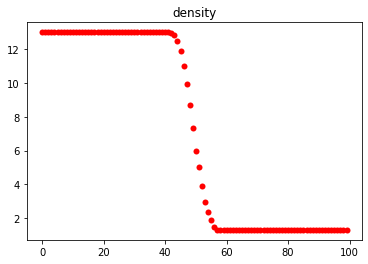

In [22]:
data = [rm.matrix[4000][i][0] for i in range(len(rm.matrix[3000]))]
x_data = [i for i in range(len(rm.matrix[3000]))]
fig1, ax1 = plt.subplots(1)
plt.title('density')
ax1.scatter(x_data, data, color='r', linewidths=0.01 ) 

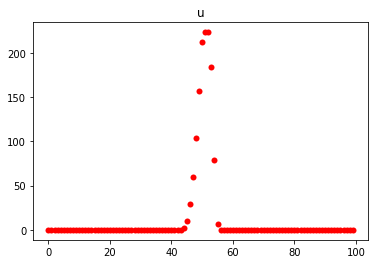

In [23]:
data = [rm.matrix[400][i][1]/rm.matrix[400][i][0] for i in range(len(rm.matrix[400]))]
x_data = [i for i in range(len(rm.matrix[400]))]
fig1, ax1 = plt.subplots(1)
plt.title('u')
ax1.scatter(x_data, data, color='r', linewidths=0.01 ) 

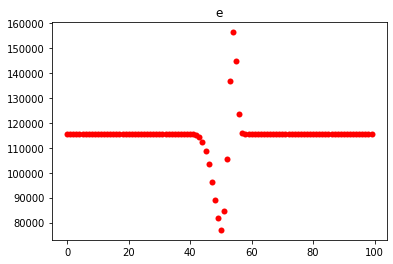

In [24]:
data = [rm.matrix[3000][i][2]/rm.matrix[3000][i][0] for i in range(len(rm.matrix[3000]))]
x_data = [i for i in range(len(rm.matrix[3000]))]
fig1, ax1 = plt.subplots(1)
plt.title('e')
ax1.scatter(x_data, data, color='r', linewidths=0.01 ) 

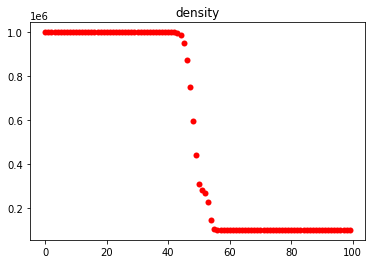

In [25]:
data = [rm.matrix[400][i][2]*(rm.gamma - 1) for i in range(len(rm.matrix[400]))]
x_data = [i for i in range(len(rm.matrix[400]))]
fig1, ax1 = plt.subplots(1)
plt.title('density')
ax1.scatter(x_data, data, color='r', linewidths=0.01 ) 